The function to extract velocity ($v$), angular velocity ($w$), and the initial direction ($\phi$) from data sampled from trajectory

import modules

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

define the function

In [2]:
from trajectory import calculate_arc

Now generate some data, starting from a perfect arc:

In [3]:
angle = math.pi * 0.5    # <--- total angle. In this case it is a quarter circle
arc = 100    # <--- arc length
R = arc / angle 

total_time = 10    # <--- time for this trajectory
phi = math.pi * 2/ 3    # <--- initial angle, 120 degree


sample_amount = 64    # <--- number of samples taken from this trajectory


t = np.arange(sample_amount) / sample_amount * total_time
alpha = -np.arange(sample_amount) * (angle / sample_amount) + phi + math.pi / 2

ox = R * math.sin(phi)
oy = -R * math.cos(phi)

px = np.cos(alpha)*R + ox 
py = np.sin(alpha)*R + oy


See the curve of alpha and distance against time:

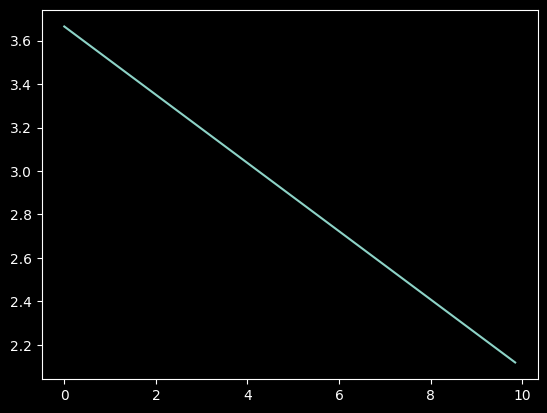

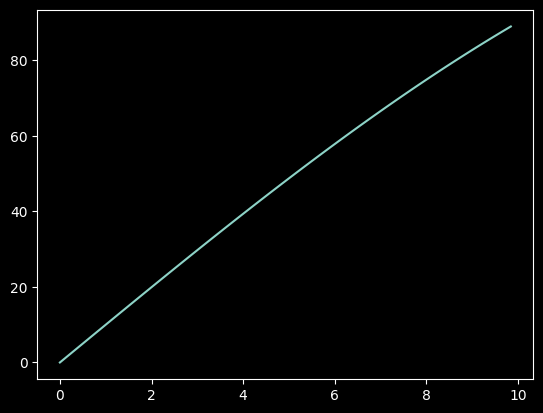

In [4]:
plt.plot(t, alpha)
plt.show()
plt.plot(t, np.sqrt(px**2 + py**2))
plt.show()

lets test the function

In [5]:
estimated_v, estimated_w, estimated_phi = calculate_arc(px, py, t)

# print out the true values and the estimated values:
print("real v:", f"{arc / 10 :<8.4f}", end="\t")
print("estimated v:", round(estimated_v, 4))

print("real w:", f"{-angle / 10 :<8.4f}", end="\t")
print("estimated w:", round(estimated_w, 4))

print("real phi:", f"{57.3*phi :<6.2f}", end="\t")
print("estimated phi:", round(estimated_phi*57.3, 2))

real v: 10.0000 	estimated v: 10.0
real w: -0.1571 	estimated w: -0.1571
real phi: 120.01	estimated phi: 120.01


Now lets add some noise:

In [6]:
angle = math.pi * 1    # <--- total angle. In this case it is half a circle
arc = 200    # <--- arc length
R = arc / angle 

total_time = 10    # <--- time for this trajectory
phi = -math.pi / 3    # <--- initial angle, -60 degree


sample_amount = 64    # <--- number of samples taken from this trajectory


t = np.arange(sample_amount) / sample_amount * total_time
alpha = -np.arange(sample_amount) * (angle / sample_amount) + phi + math.pi / 2

ox = R * math.sin(phi)
oy = -R * math.cos(phi)

px = np.cos(alpha)*R + ox 
py = np.sin(alpha)*R + oy


## | <---  add some noise to data  ---> | ##
px += np.random.normal(0, 5, sample_amount)
py += np.random.normal(0, 5, sample_amount)

See the distance relation, this time with noise

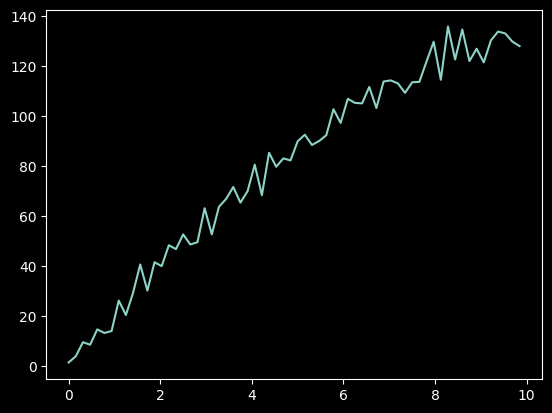

In [7]:
plt.plot(t, np.sqrt(px**2 + py**2))
plt.show()

test again:

In [8]:
estimated_v, estimated_w, estimated_phi = calculate_arc(px, py, t)

# print out the true values and the estimated values:
print("real v:", f"{arc / 10 :<8.4f}", end="\t")
print("estimated v:", round(estimated_v, 4))

print("real w:", f"{-angle / 10 :<8.4f}", end="\t")
print("estimated w:", round(estimated_w, 4))

print("real phi:", f"{57.3*phi :<6.2f}", end="\t")
print("estimated phi:", round(estimated_phi*57.3, 2))

real v: 20.0000 	estimated v: 18.9132
real w: -0.3142 	estimated w: -0.2876
real phi: -60.00	estimated phi: -64.09


The result suffers a little bit, but is still accurate. 

This seems too easy, lets try something harder.

Lets make the robot go back and forth, and also add some sideways fluctuations:

so the angle is:  $\theta(t) = \omega*t + A_{flucation}*sin(2{\pi}t/T)$,

and the radius is not fixed: $R(t) = R_0 + A_{sideways}*sin(2{\pi}t/T)$ 

In [9]:
angle = math.pi * 1.5    # <--- total angle. In this case it is one and half a circle
arc = 300    # <--- arc length
R = arc / angle 

total_time = 10    # <--- time for this trajectory
phi = math.pi * 5 / 12    # <--- initial angle, 75 degree


sample_amount = 128    # <--- number of samples taken from this trajectory


t = np.arange(sample_amount) / sample_amount * total_time
alpha = -np.arange(sample_amount) * (angle / sample_amount) + phi + math.pi / 2

ox = R * math.sin(phi)
oy = -R * math.cos(phi)


fluctuation_cycle = 10    # <--- fluctuate 5 cycles during the trajectory
fluctuation_amplitude = 0.2    # <--- forward fluctation amplitude is 20% of total angle 
sideways_amplitude = 0.1    # <--- sideways fluctuation is 10% of arc length


## | <---  we add the fluctuations  ---> | ##
alpha += angle*fluctuation_amplitude*np.sin(2*math.pi*t/total_time*fluctuation_cycle)
px = np.cos(alpha)*(R + arc*sideways_amplitude*np.sin(2*math.pi*t/total_time*fluctuation_cycle)) + ox 
py = np.sin(alpha)*(R + arc*sideways_amplitude*np.sin(2*math.pi*t/total_time*fluctuation_cycle)) + oy


# and also the noise
px += np.random.normal(0, 5, sample_amount)
py += np.random.normal(0, 5, sample_amount)


Now see how the angle and distance are affected by both the noise and the fluctuation:

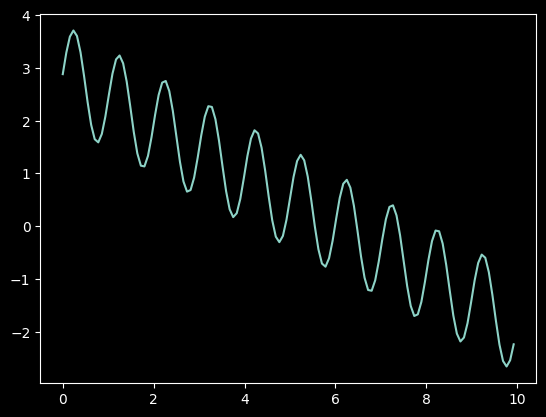

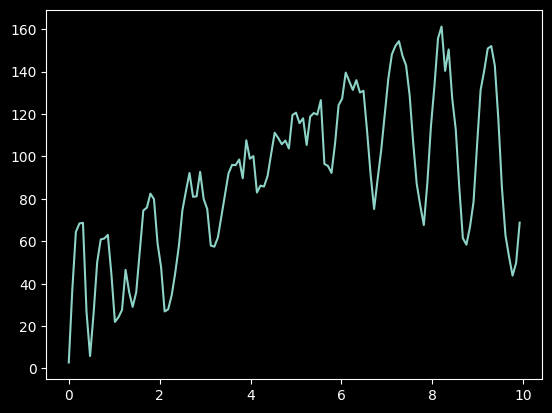

In [10]:
plt.plot(t, alpha)
plt.show()
plt.plot(t, np.sqrt(px**2 + py**2))
plt.show()

Now, the moment of truth:

In [11]:
estimated_v, estimated_w, estimated_phi = calculate_arc(px, py, t)

# print out the true values and the estimated values:
print("real v:", f"{arc / 10 :<8.4f}", end="\t")
print("estimated v:", round(estimated_v, 4))

print("real w:", f"{-angle / 10 :<8.4f}", end="\t")
print("estimated w:", round(estimated_w, 4))

print("real phi:", f"{57.3*phi :<6.2f}", end="\t")
print("estimated phi:", round(estimated_phi*57.3, 2))

real v: 30.0000 	estimated v: 27.7165
real w: -0.4712 	estimated w: -0.4256
real phi: 75.01 	estimated phi: 78.83


The function does suffer from the fluctuations further, but is still reasonably accurate.

Note that we have made the noise very large. The forward and sideways fluctuation are as large as 20% and 10% of arc, respectively.

We should see that this function is very resilient against noise and fluctuations.